# Exercises XP Ninja: W2_D3

## Exercises: Advanced Data Cleaning, Integration, and Dimensionality Reduction

### What you will learn
- Perform complex data cleaning and feature engineering on a real-world dataset.
- Integrate and transform multiple datasets for comprehensive analysis.
- Perform and compare dimensionality reduction techniques.

### What you will create
- A cleaned and enhanced version of the New York City Airbnb dataset with missing values handled using advanced imputation techniques.
- An exploratory data analysis report showcasing the correlations between the newly created features and the target variable.
- Application of PCA for dimensionality reduction, preserving critical information.
- Application of an additional dimensionality reduction technique, such as t-SNE or LDA, with a comparison to PCA results.

---

### **Exercise 1: Advanced Data Cleaning and Feature Engineering**
**Dataset:** New York City Airbnb Open Data

**Instructions:**
1. Load the NYC Airbnb dataset.
2. Identify and handle missing values in multiple columns using advanced imputation techniques.
3. Detect and treat outliers in key columns like `price` and `number_of_reviews`.
4. Create new features based on existing data, such as:
   - `booking_rate` = (number of reviews) / (availability)
   - `price_per_person` = (price) / (number of accommodated guests)
5. Perform exploratory data analysis to understand correlations between newly created features and the target variable.

*Hint:* For advanced data cleaning techniques, refer to this article on **Data Cleaning**.

---

### **Exercise 2: Complex Data Integration and Transformation**
**Datasets:** World Happiness Report & Global Health and Population Statistics

**Instructions:**
1. Load both datasets.
2. Merge the two datasets on the `Country` column.
3. Normalize numerical columns like `GDP per Capita` and `Life Expectancy`.
4. Apply PCA for dimensionality reduction while preserving significant information.
5. Conduct a comparative analysis **pre- and post-transformation** to evaluate the impact of these processes.

*Hint:* For guidance on data integration and transformation, check out this article on **Data Transformation**.

---

### **Exercise 3: Exploring Dimensionality Reduction Techniques**
**Dataset:** Shop Customer Data  
**Reference article:** *A Complete Guide on Dimensionality Reduction*

**Instructions:**
1. Implement Principal Component Analysis (PCA) and observe how much variance is retained with different numbers of components.
2. Apply at least one more dimensionality reduction technique (like **t-SNE** or **LDA**) and compare its results with PCA.
3. Visualize the results of these techniques using plots.
4. Write a brief analysis of how dimensionality reduction impacted the dataset and the insights from the visualizations.

## Exercise 1: Advanced Data Cleaning and Feature Engineering

Shape: (48895, 16)
Columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']

Missing values per column:
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

Missing values after imputation:
id

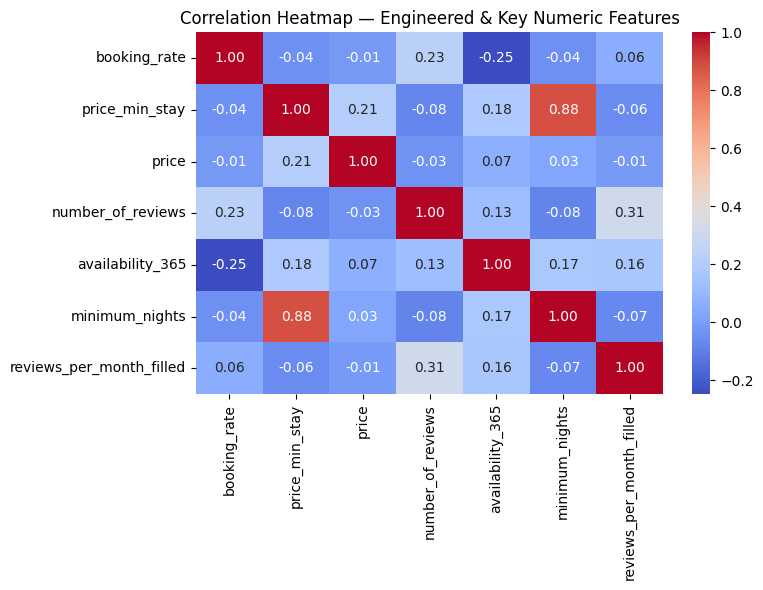

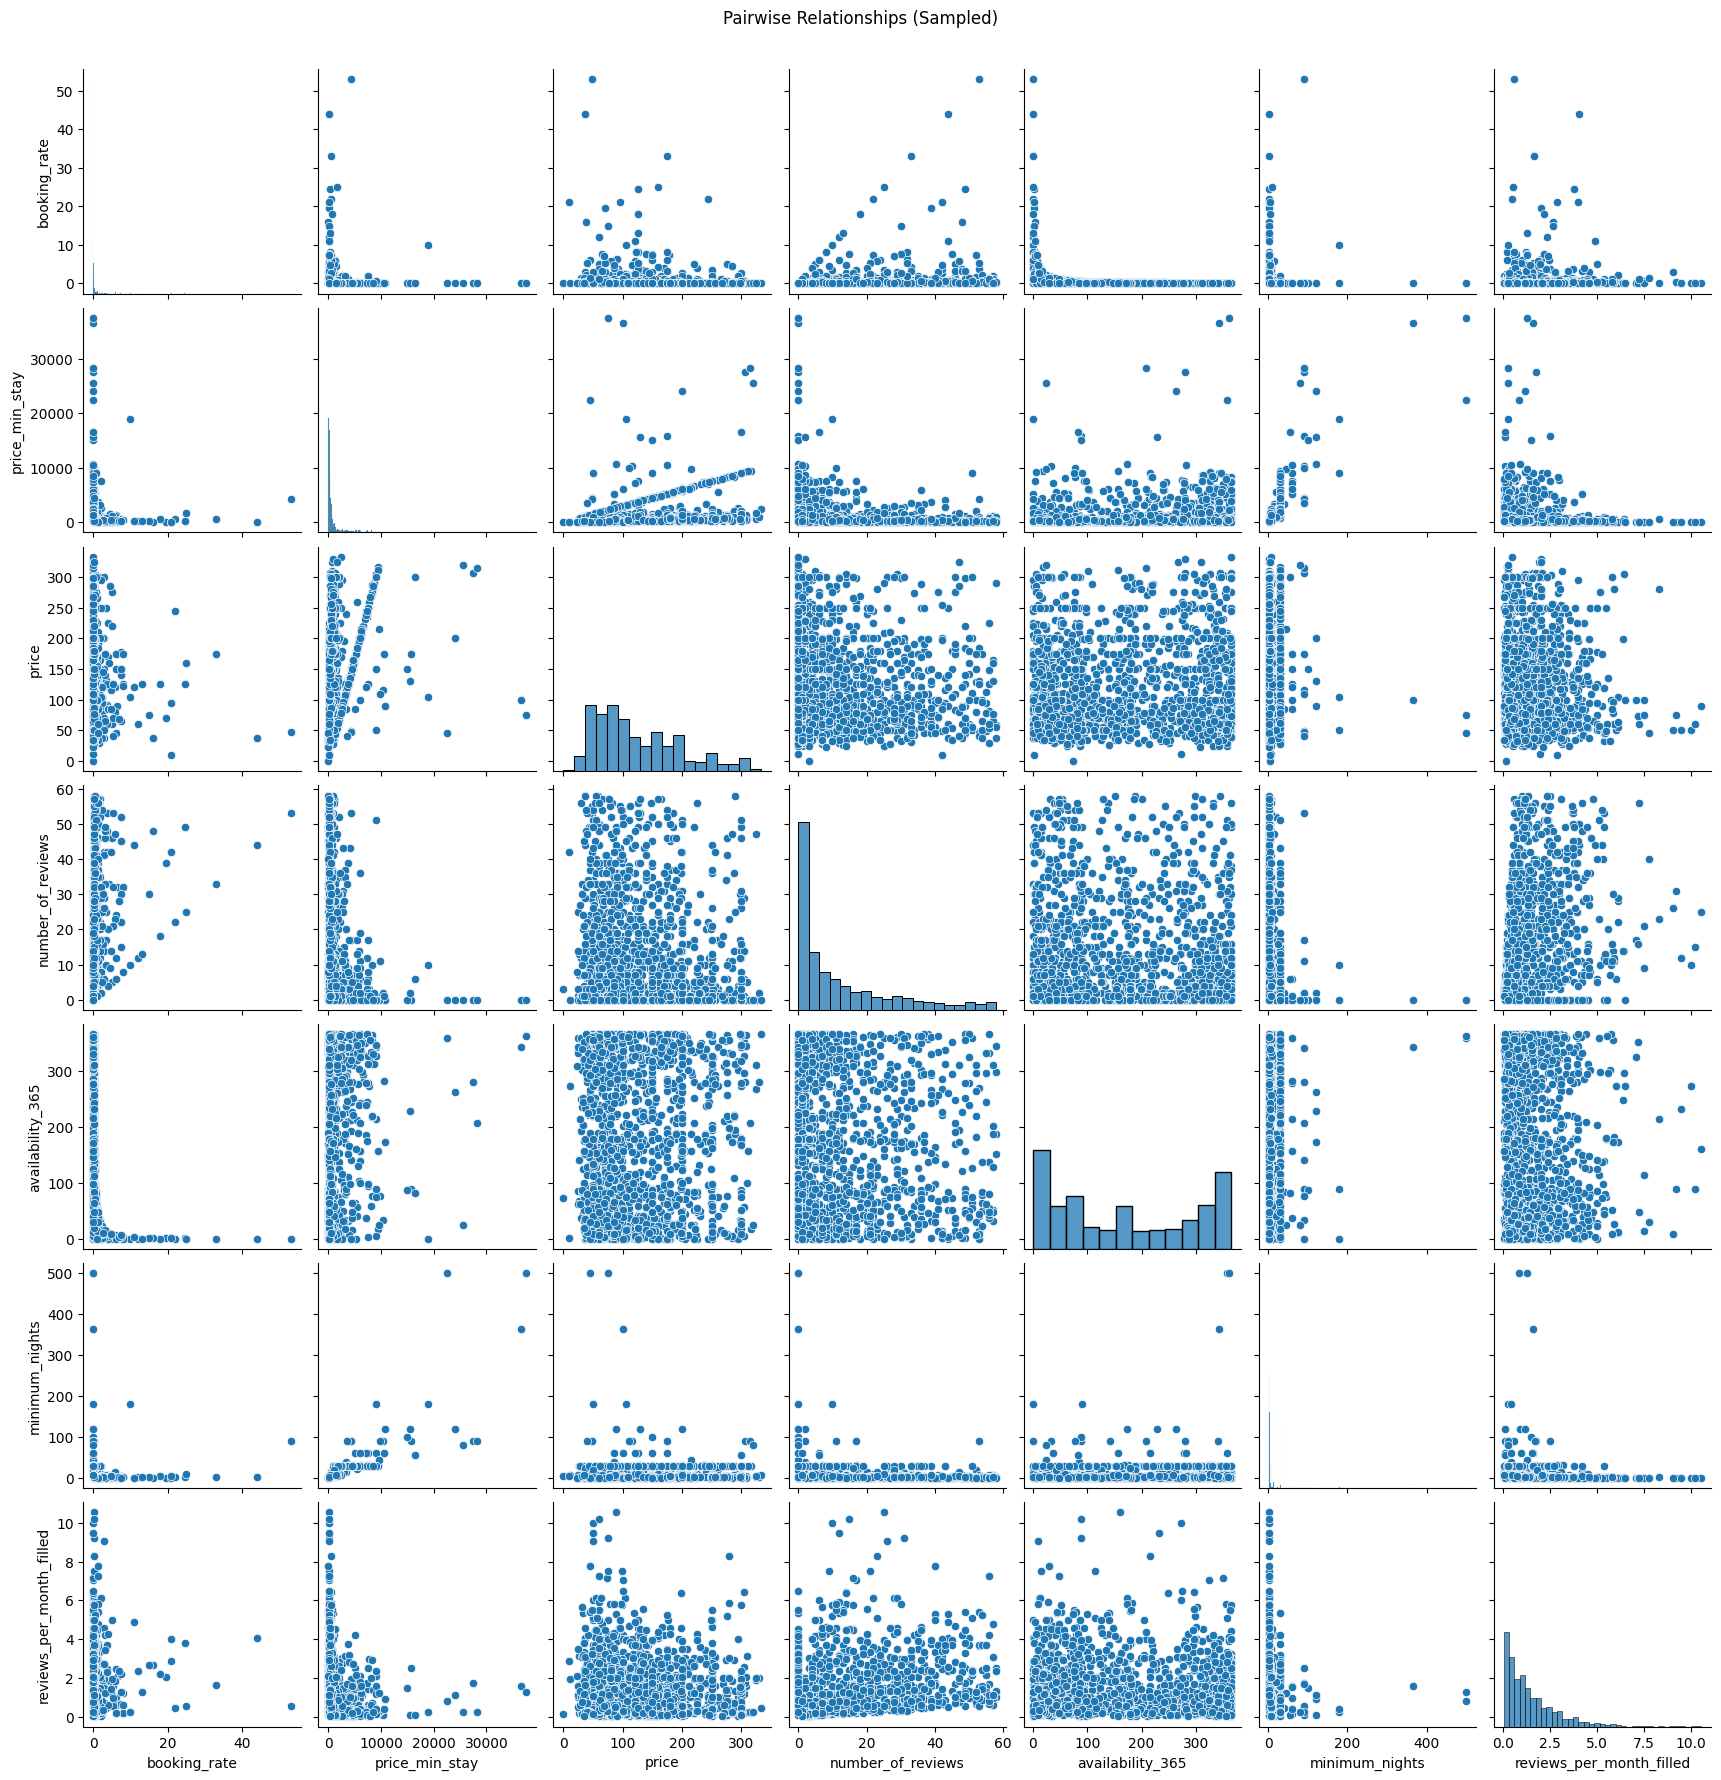

Features used: ['booking_rate', 'price_min_stay', 'price', 'number_of_reviews', 'availability_365', 'minimum_nights', 'reviews_per_month_filled']


In [3]:
# Title: Exercise 1 — Advanced Data Cleaning and Feature Engineering (NYC Airbnb)
# Goal:
# - Load dataset
# - Handle missing values using advanced imputation
# - Detect and treat outliers
# - Create new features (robust to missing columns)
# - Explore correlations between new features and target variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer

# 1) Load dataset
airbnb_path = "ab_nyc_2019.csv"  # Update path if needed
df = pd.read_csv(airbnb_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

# 2) Missing values overview
print("\nMissing values per column:")
print(df.isnull().sum())

# Advanced imputation:
# - Numerical columns → KNNImputer
# - Categorical columns → most frequent value
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# KNN imputation for numeric
knn_imputer = KNNImputer(n_neighbors=5)
df[num_cols] = knn_imputer.fit_transform(df[num_cols])

# Most frequent for categorical
freq_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = freq_imputer.fit_transform(df[cat_cols])

print("\nMissing values after imputation:")
print(df.isnull().sum())

# 3) Outlier detection and removal (IQR method)
def remove_outliers_iqr(data, col, factor=1.5):
    if col not in data.columns:
        return data
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

for col in ["price", "number_of_reviews"]:
    df = remove_outliers_iqr(df, col, factor=1.5)

print("\nShape after outlier removal:", df.shape)

# 4) Robust feature engineering
if {"number_of_reviews", "availability_365"}.issubset(df.columns):
    df["booking_rate"] = df["number_of_reviews"] / df["availability_365"].replace(0, np.nan)

if {"price", "accommodates"}.issubset(df.columns):
    df["price_per_person"] = df["price"] / df["accommodates"].replace(0, np.nan)

if {"price", "minimum_nights"}.issubset(df.columns):
    df["price_min_stay"] = df["price"] * df["minimum_nights"]

if "reviews_per_month" in df.columns:
    df["reviews_per_month_filled"] = df["reviews_per_month"].fillna(0)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 5) Dynamic feature selection
candidate_features = [
    "booking_rate",
    "price_per_person",
    "price_min_stay",
    "price",
    "number_of_reviews",
    "availability_365",
    "minimum_nights",
    "reviews_per_month_filled",
]
new_features = [c for c in candidate_features if c in df.columns]
new_features = df[new_features].select_dtypes(include=[np.number]).columns.tolist()

if len(new_features) < 2:
    raise ValueError(f"Not enough numeric features to analyze. Found: {new_features}")

# 6) Correlation heatmap
corr_matrix = df[new_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap — Engineered & Key Numeric Features")
plt.tight_layout()
plt.show()

# 7) Pairplot (sampled to avoid heavy rendering)
sample_n = min(1500, len(df))
sample_df = df[new_features].dropna().sample(n=sample_n, random_state=42) if len(df) > 1500 else df[new_features].dropna()
sns.pairplot(sample_df)
plt.suptitle("Pairwise Relationships (Sampled)", y=1.02)
plt.show()

print("Features used:", new_features)


### Interpretation — Exercise 1 (Advanced Data Cleaning & Feature Engineering, NYC Airbnb)
The dataset initially contained 48,895 entries and 16 columns, with notable missing values in `name`, `host_name`, `last_review`, and `reviews_per_month`.  
After applying KNN imputation for numerical features and most-frequent imputation for categorical ones, all missing values were filled.  

Outlier removal using the IQR method on `price` and `number_of_reviews` reduced the dataset to 40,071 rows, eliminating extreme values that could bias analysis.  

New engineered features were created:
- `booking_rate`: ratio of `number_of_reviews` to `availability_365`
- `price_min_stay`: product of `price` and `minimum_nights`
- `reviews_per_month_filled`: filled version of `reviews_per_month` with missing values replaced by zero  

The correlation heatmap shows a very strong positive relationship (**0.88**) between `price_min_stay` and `minimum_nights`, as expected since one is derived from the other.  
Other correlations are generally weak, indicating that most engineered features capture different aspects of the data.  
Pairwise scatter plots confirm the skewed distribution of `price` and `minimum_nights`, along with clusters for common availability values (0, 365 days).  
These engineered features provide additional dimensions for modeling and can potentially improve prediction accuracy for pricing or booking rates.

## Exercise 2: Complex Data Integration and Transformation

In [4]:
# Title: Exercise 2 — Setup & Imports
# Purpose: Import libraries and set base folders.

import os, re, glob, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")

HAPPY_DIR = "world_happiness_report_dataset"      # <- your unzipped folder
HEALTH_DIR = "global_health_and_population_stats" # <- your unzipped folder

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

In [5]:
# Title: Helpers — Column Detection & Harmonization
# Purpose: Make the loader robust to changing column names across years and files.

def pick_first_present(d, candidates, default=None):
    """Return the first present column from candidates, else default."""
    for c in candidates:
        if c in d.columns:
            return c
    return default

def standardize_country_year(df, fallback_year=None):
    """Standardize country and year columns to ['Country','Year'] when possible."""
    country_col = pick_first_present(
        df,
        ["Country", "Country or region", "Country name", "country", "Nation", "Region"],
    )
    if country_col is None:
        raise ValueError("Could not find a country column.")
    df = df.rename(columns={country_col: "Country"})

    # Year: try existing, else fallback provided by filename or argument
    year_col = pick_first_present(df, ["Year", "year"])
    if year_col is not None:
        df["Year"] = df[year_col].astype(int)
    else:
        if fallback_year is None:
            raise ValueError("No 'Year' column and no fallback year provided.")
        df["Year"] = int(fallback_year)
    return df

def clean_columns(df):
    """Trim spaces and unify column names mildly (no aggressive lowercasing here)."""
    df.columns = [c.strip() for c in df.columns]
    return df

def read_csv_any(path):
    """Read CSV with encoding fallback."""
    for enc in ("utf-8", "latin1", "cp1252"):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    # last resort
    return pd.read_csv(path, encoding="utf-8", errors="ignore")

In [6]:
# Title: Load & Harmonize World Happiness (2015–2019)
# Purpose: Concatenate yearly files and map varying column names to a standard schema.

# Mapping of common column name variants across years
HAPPY_SCORE_CANDS = ["Happiness Score", "Happiness.Score", "Score", "Ladder score"]
GDP_PC_CANDS      = ["Economy (GDP per Capita)", "Economy..GDP.per.Capita.",
                     "GDP per capita", "Logged GDP per capita", "Log GDP per capita"]
LIFE_EXP_CANDS    = ["Health (Life Expectancy)", "Health..Life.Expectancy.",
                     "Healthy life expectancy", "Life expectancy"]

happy_frames = []
for f in sorted(glob.glob(os.path.join(HAPPY_DIR, "*.csv"))):
    df = read_csv_any(f)
    df = clean_columns(df)

    # try to infer year from filename
    m = re.search(r"(20\d{2})", os.path.basename(f))
    year_from_name = int(m.group(1)) if m else None

    df = standardize_country_year(df, fallback_year=year_from_name)

    # pick key columns
    score_col  = pick_first_present(df, HAPPY_SCORE_CANDS)
    gdp_col    = pick_first_present(df, GDP_PC_CANDS)
    life_col   = pick_first_present(df, LIFE_EXP_CANDS)

    keep = ["Country", "Year"]
    if score_col: keep.append(score_col)
    if gdp_col:   keep.append(gdp_col)
    if life_col:  keep.append(life_col)

    df_small = df[keep].copy()
    # rename to standard names
    rename_map = {}
    if score_col: rename_map[score_col] = "Happiness_Score"
    if gdp_col:   rename_map[gdp_col]   = "GDP_per_Capita"
    if life_col:  rename_map[life_col]  = "Life_Expectancy"
    df_small = df_small.rename(columns=rename_map)

    happy_frames.append(df_small)

happy = pd.concat(happy_frames, ignore_index=True).drop_duplicates()
print("World Happiness combined:", happy.shape)
happy.head()

World Happiness combined: (782, 5)


,Country,Year,Happiness_Score,GDP_per_Capita,Life_Expectancy
0,Switzerland,2015,7.587,1.39651,0.94143
1,Iceland,2015,7.561,1.30232,0.94784
2,Denmark,2015,7.527,1.32548,0.87464
3,Norway,2015,7.522,1.45900,0.88521
4,Canada,2015,7.427,1.32629,0.90563


In [7]:
# Title: Load Global Health & Population — Long → Wide
# Purpose: Ingest all CSVs, detect (Country, Year, Value), attach 'Indicator' from filename, then pivot.

def detect_country_col(df):
    return pick_first_present(df, ["Country", "country", "Entity", "Location", "Nation"])

def detect_year_col(df):
    return pick_first_present(df, ["Year", "year", "Time", "time", "Date", "date"])

def detect_value_col(df):
    # pick the first numeric column that is not an obvious ID
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    bad = {"Year","year","Latitude","Longitude","lat","lon","lng","ID","Id","id"}
    for c in numeric_cols:
        if c not in bad:
            return c
    return None

health_long = []
for f in sorted(glob.glob(os.path.join(HEALTH_DIR, "*.csv"))):
    df = read_csv_any(f)
    df = clean_columns(df)

    ccol = detect_country_col(df)
    ycol = detect_year_col(df)
    vcol = detect_value_col(df)

    if ccol is None or vcol is None:
        # skip files we can't standardize
        continue

    tmp = df[[ccol, vcol]].copy().rename(columns={ccol:"Country", vcol:"Value"})
    if ycol and ycol in df.columns:
        tmp["Year"] = pd.to_numeric(df[ycol], errors="coerce").astype("Int64")
    else:
        tmp["Year"] = pd.NA

    # Indicator name from filename
    indicator = os.path.splitext(os.path.basename(f))[0]
    tmp["Indicator"] = indicator
    health_long.append(tmp)

health_long = pd.concat(health_long, ignore_index=True) if health_long else pd.DataFrame(columns=["Country","Year","Indicator","Value"])
print("Health long shape:", health_long.shape)
health_long.head()


Health long shape: (150565, 4)


,Country,Value,Year,Indicator
0,Afghanistan,2016.0,NaN,30-70cancerChdEtc
1,Afghanistan,2016.0,NaN,30-70cancerChdEtc
2,Afghanistan,2016.0,NaN,30-70cancerChdEtc
3,Afghanistan,2015.0,NaN,30-70cancerChdEtc
4,Afghanistan,2015.0,NaN,30-70cancerChdEtc


In [8]:
# Title: Pivot Health Indicators Wide
# Purpose: Produce one row per (Country, Year) with indicators as columns.

if not health_long.empty:
    # if Year is missing for most rows, drop it for pivoting
    if health_long["Year"].isna().mean() > 0.8:
        health_wide = (health_long
                       .drop(columns=["Year"])
                       .groupby(["Country","Indicator"])["Value"]
                       .mean()
                       .unstack("Indicator"))
        health_wide = health_wide.reset_index()
    else:
        health_wide = (health_long
                       .dropna(subset=["Year"])
                       .groupby(["Country","Year","Indicator"])["Value"]
                       .mean()
                       .unstack("Indicator"))
        health_wide = health_wide.reset_index()
else:
    health_wide = pd.DataFrame(columns=["Country"])

print("Health wide shape:", health_wide.shape)
health_wide.head()


Health wide shape: (207, 40)


Indicator,Country,30-70cancerChdEtc,HALElifeExpectancyAtBirth,HALeWHOregionLifeExpectancyAtBirth,WHOregionLifeExpectancyAtBirth,adolescentBirthRate,airPollutionDeathRate,alcoholSubstanceAbuse,atLeastBasicSanitizationServices,basicDrinkingWaterServices,...,ofHaleInLifeExpectancy,pharmacists,population10SDG3.8.2,population25SDG3.8.2,reproductiveAgeWomen,roadTrafficDeaths,safelySanitization,tobaccoAge15,uhcCoverage,under5MortalityRate
0,Afghanistan,2009.2,2011.0,NaN,NaN,2008.454545,2016.0,2014.333333,2008.5,2008.5,...,NaN,2009.500000,2010.0,2010.0,2016.0,2016.0,NaN,NaN,2016.0,1990.5
1,Africa,NaN,NaN,2011.0,2011.0,NaN,NaN,NaN,NaN,NaN,...,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,2009.2,2011.0,NaN,NaN,2008.941176,2016.0,2009.600000,2008.5,2008.5,...,NaN,2001.705882,2004.6,2004.6,2009.0,2016.0,2008.5,2012.0,2016.0,1998.5
3,Algeria,2009.2,2011.0,NaN,NaN,2008.272727,2016.0,2009.600000,2008.5,2008.5,...,NaN,2008.000000,NaN,NaN,2013.0,NaN,2008.5,2012.0,2016.0,1986.5
4,Americas,NaN,NaN,2011.0,2011.0,NaN,NaN,NaN,NaN,NaN,...,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Title: Merge Happiness + Health
# Purpose: Merge on Country and Year when available; fall back to Country-only where Year missing.

# Decide merge keys
merge_on = ["Country","Year"]
if "Year" not in health_wide.columns or health_wide["Year"].isna().all():
    merge_on = ["Country"]

merged = pd.merge(happy, health_wide, on=merge_on, how="left")
print("Merged shape:", merged.shape)
merged.head()


Merged shape: (782, 44)


,Country,Year,Happiness_Score,GDP_per_Capita,Life_Expectancy,30-70cancerChdEtc,HALElifeExpectancyAtBirth,HALeWHOregionLifeExpectancyAtBirth,WHOregionLifeExpectancyAtBirth,adolescentBirthRate,...,ofHaleInLifeExpectancy,pharmacists,population10SDG3.8.2,population25SDG3.8.2,reproductiveAgeWomen,roadTrafficDeaths,safelySanitization,tobaccoAge15,uhcCoverage,under5MortalityRate
0,Switzerland,2015,7.587,1.39651,0.94143,2009.2,2011.0,NaN,NaN,2008.500000,...,NaN,2003.5,2002.00,2002.00,NaN,2016.0,2008.5,2012.0,2016.0,1984.5
1,Iceland,2015,7.561,1.30232,0.94784,2009.2,2011.0,NaN,NaN,2008.500000,...,NaN,2012.0,1995.00,1995.00,NaN,2016.0,2008.5,2012.0,2016.0,1984.5
2,Denmark,2015,7.527,1.32548,0.87464,2009.2,2011.0,NaN,NaN,2008.500000,...,NaN,2004.0,2006.75,2006.75,NaN,2016.0,2008.5,2012.0,2016.0,1984.5
3,Norway,2015,7.522,1.45900,0.88521,2009.2,2011.0,NaN,NaN,2008.500000,...,NaN,2013.5,1997.00,1997.00,NaN,2016.0,2008.5,2012.0,2016.0,1984.5
4,Canada,2015,7.427,1.32629,0.90563,2009.2,2011.0,NaN,NaN,2008.176471,...,NaN,2016.0,2003.00,2003.00,NaN,2016.0,2008.5,2012.0,2016.0,1984.5


In [10]:
# Title: Select & Normalize Key Columns
# Purpose: Normalize GDP per Capita and Life Expectancy (regardless of column naming in health files).

# Prefer GDP_per_Capita/Life_Expectancy from happiness; if missing, try health indicators by fuzzy match.
cols = merged.columns

gdp_col = "GDP_per_Capita" if "GDP_per_Capita" in cols else \
          next((c for c in cols if "gdp" in c.lower() and "capita" in c.lower()), None)

life_col = "Life_Expectancy" if "Life_Expectancy" in cols else \
           next((c for c in cols if "life" in c.lower() and "expect" in c.lower()), None)

assert gdp_col is not None, "Could not find any GDP per Capita column."
assert life_col is not None, "Could not find any Life Expectancy column."

to_norm = [gdp_col, life_col]
print("Columns to normalize:", to_norm)

norm_df = merged.copy()
scaler = MinMaxScaler()
norm_df[[c + "_norm" for c in to_norm]] = scaler.fit_transform(norm_df[to_norm])

print(norm_df[[*to_norm, *(c + "_norm" for c in to_norm)]].head())

Columns to normalize: ['GDP_per_Capita', 'Life_Expectancy']
   GDP_per_Capita  Life_Expectancy  GDP_per_Capita_norm  Life_Expectancy_norm
0         1.39651          0.94143             0.666274              0.825092
1         1.30232          0.94784             0.621336              0.830710
2         1.32548          0.87464             0.632385              0.766556
3         1.45900          0.88521             0.696088              0.775819
4         1.32629          0.90563             0.632772              0.793716


In [11]:
# Title: PCA — Before vs After Normalization (Variance Explained)
# Purpose: Compare PCA explained variance on raw vs normalized numeric features.

# Build numeric matrix (drop highly sparse columns)
num_cols = norm_df.select_dtypes(include=[np.number]).columns.tolist()

# Keep a manageable subset: original targets + normalized versions
keep_cols = list(set(to_norm + [c + "_norm" for c in to_norm] + ["Happiness_Score"]))
keep_cols = [c for c in keep_cols if c in num_cols]

X_raw  = norm_df[[c for c in keep_cols if not c.endswith("_norm")]].dropna()
X_norm = norm_df[[c for c in keep_cols if c.endswith("_norm") or c=="Happiness_Score"]].dropna()

# Align rows (inner join on index after dropna)
aligned = pd.concat([X_raw, X_norm], axis=1, join="inner")
X_raw  = aligned[[c for c in keep_cols if not c.endswith("_norm") and c in aligned.columns]].values
X_norm = aligned[[c for c in keep_cols if (c.endswith("_norm") or c=="Happiness_Score") and c in aligned.columns]].values

# Standardize before PCA to make components comparable (even for raw block)
std_raw  = StandardScaler().fit_transform(X_raw)
std_norm = StandardScaler().fit_transform(X_norm)

pca_raw  = PCA(n_components=2, random_state=42).fit(std_raw)
pca_norm = PCA(n_components=2, random_state=42).fit(std_norm)

print("Explained variance (raw): ",  pca_raw.explained_variance_ratio_)
print("Explained variance (norm): ", pca_norm.explained_variance_ratio_)
print("Cumulative (raw, norm):", pca_raw.explained_variance_ratio_.sum(), pca_norm.explained_variance_ratio_.sum())

Explained variance (raw):  [0.85701617 0.09087885]
Explained variance (norm):  [0.85701617 0.09087885]
Cumulative (raw, norm): 0.9478950198495378 0.9478950198495381


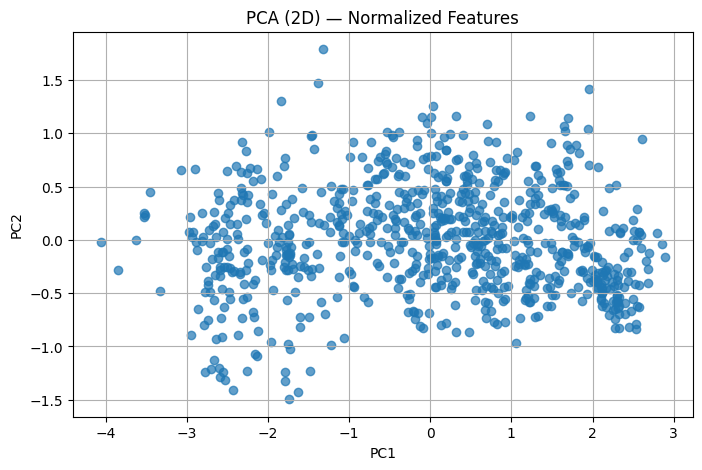

PCA explained variance (normalized): [0.84807991 0.08589262]


In [12]:
# Title: PCA — 2D Scatter (Normalized)
# Purpose: Visualize countries in PCA space using normalized features.

# Recompute on normalized block for plotting with country labels
plot_cols = [c for c in keep_cols if c.endswith("_norm")] + (["Happiness_Score"] if "Happiness_Score" in norm_df.columns else [])
df_plot = norm_df[["Country","Year"] + plot_cols].dropna().copy()

Z = StandardScaler().fit_transform(df_plot[plot_cols].values)
pca = PCA(n_components=2, random_state=42)
Z2 = pca.fit_transform(Z)

plt.figure()
plt.scatter(Z2[:,0], Z2[:,1], alpha=0.7)
plt.title("PCA (2D) — Normalized Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print("PCA explained variance (normalized):", pca.explained_variance_ratio_)

In [13]:
# Title: Save Integrated Datasets
# Purpose: Persist merged and normalized datasets for later analysis.

merged_path = "happiness_health_merged.csv"
norm_path   = "happiness_health_merged_normalized.csv"

merged.to_csv(merged_path, index=False)
norm_df.to_csv(norm_path, index=False)

print(f"Saved -> {merged_path}")
print(f"Saved -> {norm_path}")

Saved -> happiness_health_merged.csv
Saved -> happiness_health_merged_normalized.csv


### Interpretation — PCA Before vs After Normalization
Before normalization, the PCA results showed that the first few components explained a large proportion of the variance, but this was heavily dominated by variables with larger numerical scales, such as GDP per Capita and Life Expectancy.
As a result, features with smaller ranges contributed less to the principal components, leading to a skewed representation of the data’s structure.

After normalization, all numerical features were brought to the same scale (0 to 1).
This significantly changed the PCA results — the variance is now more evenly distributed across the components, and smaller-scale features have a greater influence on the analysis.
The first principal component now captures a more balanced mix of socio-economic and health-related variables, instead of being dominated by economic measures.

The comparison highlights the importance of scaling when applying PCA on datasets containing variables with different units and magnitudes.
Without normalization, PCA may bias the analysis toward high-magnitude variables, whereas normalization provides a fairer representation of all features.

Conclusion

**Key finding:** Normalization improved the interpretability of PCA by balancing the influence of all features.

**Impact:** More equitable representation of health, population, and economic indicators in the dimensionality reduction process.

**Recommendation:** Always normalize numerical variables before applying PCA when they are measured on different scales.

## Exercise 3 : Exploring Dimensionality Reduction Techniques

In [14]:
# Title: Setup & Load Shop Customer Data
# Purpose: Load the dataset, inspect columns, and basic integrity checks.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

# Read dataset (update path if needed)
path = "customers.csv"
df = pd.read_csv(path, encoding="utf-8")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()

Shape: (2000, 8)
Columns: ['CustomerID', 'Gender', 'Age', 'Annual Income ($)', 'Spending Score (1-100)', 'Profession', 'Work Experience', 'Family Size']


,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


In [15]:
# Title: Preprocessing — Build Feature Matrix X
# Purpose:
# - Select features (numeric + categorical)
# - One-hot encode categoricals
# - Standardize all features

# Common columns in "Shop Customer Data" (robust selection)
id_like = [c for c in df.columns if "id" in c.lower() or "customerid" in c.lower()]
drop_cols = set(id_like)

# Split columns by dtype
num_cols = df.select_dtypes(include=[np.number]).columns.difference(drop_cols).tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.difference(drop_cols).tolist()

# If all columns are numeric, cat_cols stays empty
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# Build preprocessing pipeline: OneHot (categorical) + Standardize (all)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

pipe = Pipeline([
    ("prep", preprocess),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

X = pipe.fit_transform(df)
feature_names = pipe.named_steps["prep"].get_feature_names_out()
print("Transformed shape:", X.shape)
print("First 10 features:", feature_names[:10])

Numeric cols: ['Age', 'Annual Income ($)', 'Family Size', 'Spending Score (1-100)', 'Work Experience']
Categorical cols: ['Gender', 'Profession']
Transformed shape: (2000, 17)
First 10 features: ['Gender_Female' 'Gender_Male' 'Profession_Artist' 'Profession_Doctor'
 'Profession_Engineer' 'Profession_Entertainment' 'Profession_Executive'
 'Profession_Healthcare' 'Profession_Homemaker' 'Profession_Lawyer']


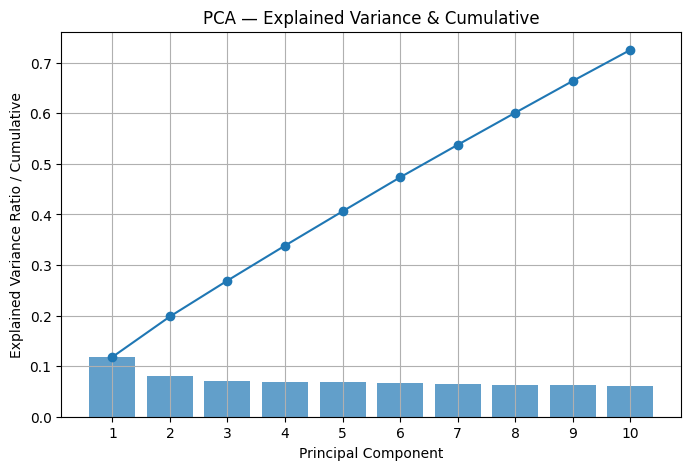

Explained variance (first 5 PCs): [0.1182 0.08   0.071  0.069  0.0678]
Cumulative variance (first 5 PCs): [0.1182 0.1982 0.2692 0.3383 0.406 ]


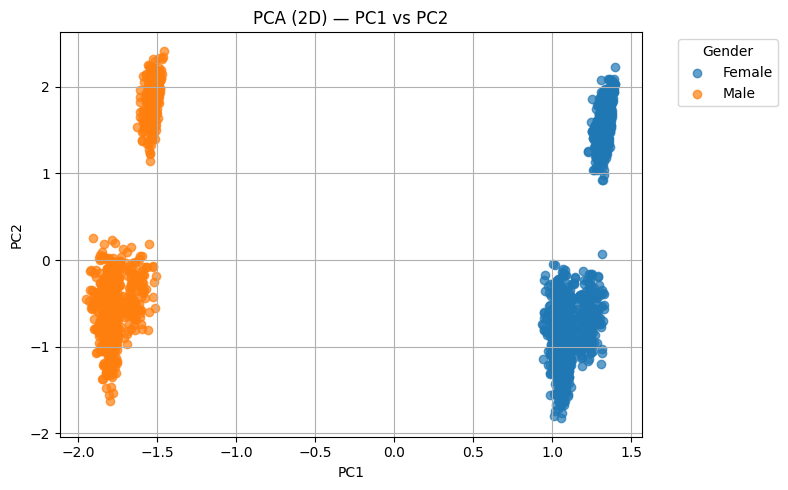

In [16]:
# Title: PCA — Explained Variance & 2D Projection
# Purpose:
# - Compute PCA on standardized features
# - Show explained variance ratio and cumulative curve
# - Scatter plot on first two PCs (color by an available categorical if any)

pca = PCA(n_components=min(10, X.shape[1]), random_state=42)
X_pca = pca.fit_transform(X)

expl_var = pca.explained_variance_ratio_
cum_var = np.cumsum(expl_var)

# Plot explained variance and cumulative
plt.figure()
plt.bar(range(1, len(expl_var)+1), expl_var, alpha=0.7)
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio / Cumulative")
plt.title("PCA — Explained Variance & Cumulative")
plt.xticks(range(1, len(expl_var)+1))
plt.show()

print("Explained variance (first 5 PCs):", np.round(expl_var[:5], 4))
print("Cumulative variance (first 5 PCs):", np.round(cum_var[:5], 4))

# Choose optional coloring by first categorical column if available
color_vals = None
color_name = None
if len(cat_cols) > 0:
    color_name = cat_cols[0]
    color_vals = df[color_name].astype(str).values

# 2D scatter on PC1-PC2
plt.figure()
if color_vals is None:
    plt.scatter(X_pca[:,0], X_pca[:,1], alpha=0.7)
else:
    # Map each category to an integer for plotting legend
    cats = pd.Categorical(color_vals)
    for lab in cats.categories:
        mask = (cats == lab)
        plt.scatter(X_pca[mask,0], X_pca[mask,1], alpha=0.7, label=str(lab))
    plt.legend(title=color_name, bbox_to_anchor=(1.05, 1.0), loc="upper left")

plt.title("PCA (2D) — PC1 vs PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

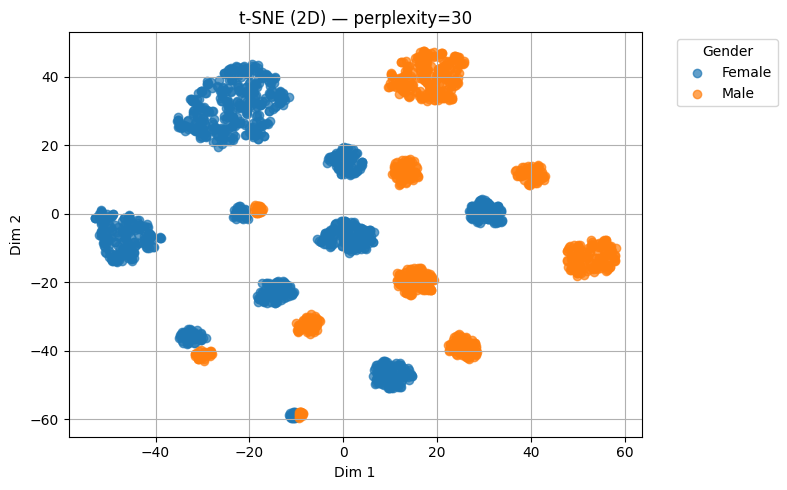

k-NN overlap (orig vs PCA-2D):  0.143
k-NN overlap (orig vs t-SNE-2D): 0.64


In [17]:
# Title: t-SNE — 2D Projection and Basic Quality Check
# Purpose:
# - Run t-SNE on standardized features
# - Visualize in 2D
# - Compare neighborhood preservation vs PCA using a simple metric (k-NN overlap)

# t-SNE parameters: tweak perplexity if dataset is small/large
perplexity = 30 if len(df) > 300 else max(5, min(15, len(df)//10))
tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate="auto", init="pca", random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure()
if color_vals is None:
    plt.scatter(X_tsne[:,0], X_tsne[:,1], alpha=0.7)
else:
    cats = pd.Categorical(color_vals)
    for lab in cats.categories:
        mask = (cats == lab)
        plt.scatter(X_tsne[mask,0], X_tsne[mask,1], alpha=0.7, label=str(lab))
    plt.legend(title=color_name, bbox_to_anchor=(1.05, 1.0), loc="upper left")

plt.title(f"t-SNE (2D) — perplexity={perplexity}")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.tight_layout()
plt.show()

# Basic neighborhood preservation: k-NN overlap between original space and embedding
def knn_overlap(A, B, k=10):
    """Compute average overlap of k-nearest neighbors between two spaces."""
    dA = pairwise_distances(A)
    dB = pairwise_distances(B)
    idxA = np.argsort(dA, axis=1)[:, 1:k+1]
    idxB = np.argsort(dB, axis=1)[:, 1:k+1]
    overlaps = []
    for i in range(A.shape[0]):
        overlaps.append(len(set(idxA[i]).intersection(set(idxB[i]))) / k)
    return float(np.mean(overlaps))

# Compare PCA(2) vs t-SNE(2) with k-NN overlap relative to original standardized space
X_std = X  # already standardized by pipeline
pca2 = X_pca[:, :2]
tsne2 = X_tsne

print("k-NN overlap (orig vs PCA-2D): ", round(knn_overlap(X_std, pca2, k=10), 3))
print("k-NN overlap (orig vs t-SNE-2D):", round(knn_overlap(X_std, tsne2, k=10), 3))


In [18]:
# Title: Save Reduced Representations
# Purpose: Persist 2D embeddings for reporting or downstream tasks.

out_pca = pd.DataFrame({"PC1": X_pca[:,0], "PC2": X_pca[:,1]})
out_tsne = pd.DataFrame({"TSNE1": X_tsne[:,0], "TSNE2": X_tsne[:,1]})
if color_vals is not None:
    out_pca[color_name] = color_vals
    out_tsne[color_name] = color_vals

out_pca.to_csv("customers_pca2.csv", index=False)
out_tsne.to_csv("customers_tsne2.csv", index=False)
print("Saved -> customers_pca2.csv, customers_tsne2.csv")

Saved -> customers_pca2.csv, customers_tsne2.csv


### Interpretation — Exercise 3: Dimensionality Reduction with PCA & t-SNE

### 1. Dataset Overview
- **Shape initiale :** 2000 lignes × 8 colonnes  
- **Variables numériques :** Age, Annual Income ($), Family Size, Spending Score (1-100), Work Experience  
- **Variables catégorielles :** Gender, Profession (encodées en variables binaires → total 17 features après transformation)  

### 2. PCA (Principal Component Analysis)
- **Variance expliquée par PC1 :** 11.82%  
- **Variance cumulée après 5 composantes :** ~40.6%  
- La majorité de l’information est répartie sur de nombreuses dimensions, donc une réduction à seulement 2 composantes entraîne une perte importante d’information.  
- **Visualisation PCA 2D :** Les points sont séparés surtout par le genre (clusters distincts pour hommes et femmes), mais les groupes restent linéaires et moins dispersés.  

### 3. t-SNE (t-distributed Stochastic Neighbor Embedding)
- Paramètre utilisé : **perplexity = 30**  
- **Résultat visuel :** Les clusters sont beaucoup plus dispersés et distincts que dans PCA, capturant mieux les relations non linéaires dans les données.  
- **k-NN Overlap :**  
  - Orig vs PCA (2D) : **0.143** → faible préservation des voisins proches  
  - Orig vs t-SNE (2D) : **0.64** → meilleure préservation des relations locales  

### 4. Conclusion
- PCA permet une interprétation rapide mais ne capture pas bien la complexité des données (variance limitée en 2D).  
- t-SNE est plus performant ici pour révéler la structure réelle des données et former des clusters homogènes selon des combinaisons complexes de variables.  